<a href="https://colab.research.google.com/github/MatteoGioia/ViT2MLPMixerKD/blob/main/ViT2MLPKD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Knowledge distillation
In this notebook, we will try to distill the knowledge of a Vision Transformer into a MLP Mixer.

##0. Setup

### 0.1 Downloads and imports

In [1]:
#@title Downloads
!pip install -q transformers datasets[vision] pytorch-lightning
!pip install -q wandb
!pip install -q einops
!pip install -q timm

In [2]:
#@title Imports

# general imports
from typing import *
import os
import random
from pathlib import Path
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
import wandb

# pytorch imports
import torchvision
import pytorch_lightning as pl
from pytorch_lightning import callbacks
import transformers
#from transformers import ViTFeatureExtractor, ViTForImageClassification
import torch

import numpy as np
import einops
import torch.nn as nn
import torch.nn.functional as F

#mlp mixer import
import timm

seed : int = 42
device : str = "cuda" if torch.cuda.is_available() else "cpu"
pl.seed_everything(seed)
print(f"You are going to train the distillation on {device}")

Global seed set to 42


You are going to train the distillation on cuda


In [ ]:
#@title Download imagenet64
#Warning: the total size (zip + untarred file) is 20 gb!

!wget https://pjreddie.com/media/files/imagenet64.tar 
!tar -xvf imagenet64.tar
!rm -rf imagenet64.tar

def get_imagenet64_data():
  # Data augmentation transformations. Not for Testing!
  transform_train = torchvision.transforms.Compose([
    torchvision.transforms.Resize(64), # Takes images smaller than 64 and enlarges them
    torchvision.transforms.RandomCrop(64, padding=4, padding_mode='edge'), # Take 64x64 crops from 72x72 padded images
    torchvision.transforms.RandomHorizontalFlip(),    # 50% of time flip image along y-axis
    torchvision.transforms.ToTensor(),
  ])

  transform_test = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
  ])

  trainset = torchvision.datasets.ImageFolder(root='./imagenet64/train/', transform=transform_train)
  #trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=4)

  testset = torchvision.datasets.ImageFolder(root='./imagenet64/val/', transform=transform_test)
  #testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False, num_workers=4)

  return trainset, testset

imnet64_train, imnet64_test = get_imagenet64_data()

--2022-12-13 14:15:04--  https://pjreddie.com/media/files/imagenet64.tar
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10033909760 (9.3G) [application/octet-stream]
Saving to: ‘imagenet64.tar’

imagenet64.tar      100%[===================>]   9.34G  23.9MB/s    in 9m 57s  

2022-12-13 14:25:01 (16.0 MB/s) - ‘imagenet64.tar’ saved [10033909760/10033909760]



FileNotFoundError: [Errno 2] No such file or directory: './imagenet64/train/'

In [ ]:
#@title Download cifar100
cifar100_train = torchvision.datasets.CIFAR100(root = ".",
                                               train = True,
                                               download = True,
                                               transform=torchvision.transforms.functional.pil_to_tensor)
cifar100_test = torchvision.datasets.CIFAR100(root = ".",
                                               train = False,
                                               download = True,
                                               transform=torchvision.transforms.functional.pil_to_tensor)

  0%|          | 0/169001437 [00:00<?, ?it/s]

Extracting ./cifar-100-python.tar.gz to .
Files already downloaded and verified


###0.2 Utility functions

In [ ]:
#@title Visualization function
def visualize(datapoint : int, dataset : torchvision.datasets):
    image, label = dataset[datapoint]
    plt.title(f"Ground truth: {dataset.classes[label]}")
    plt.imshow(torchvision.transforms.functional.to_pil_image(image))

In [ ]:
#@title Function to output a prediction of the teacher
def predict(image : torch.Tensor,
            model : nn.Module,
            feature_extractor : Any = None) -> str:
    with torch.no_grad():
        if feature_extractor is None:
            logits = model(image)
        else:
            inputs : torch.Tensor = feature_extractor(image, return_tensors="pt").to(device)
            logits = model(**inputs).logits
      
    # model predicts one of the classes
    predicted_label : int = logits.argmax(-1).item()
   
    return predicted_label


In [ ]:
#@title Count the parameters of a model
def count_params(model : nn.Module) -> int:
    parameters = filter(lambda p: p.requires_grad, model.parameters())
    param_num = sum([np.prod(p.size()) for p in parameters]) / 1_000_000
    return param_num

##1. Code for the models

###1.1 Pre-trained teacher (ViT)
Load ViT finetuned on Imagenet1k or CIFAR100. To load the non fine-tuned version use **"google/vit-base-patch16-224-im21k"**

References:
- [main transformer docs](https:huggingface.co/docs/transformers/index) 
- [ViT Docs](https://huggingface.co/docs/transformers/model_doc/vit)
- [lighting finetuning example](https://github.com/NielsRogge/Transformers-Tutorials/tree/master/VisionTransformer)

In [ ]:
#@title Load the model
cifar100_vit = "Ahmed9275/Vit-Cifar100"
imagenet1k_vit = "google/vit-base-patch16-224"
tuned_on : str = "imagenet1k" #@param['cifar100', 'imagenet1k']
if tuned_on == "cifar100":
    model_str = cifar100_vit
else:
    model_str = imagenet1k_vit


feature_extractor = transformers.ViTFeatureExtractor.from_pretrained(model_str)if 

teacher = transformers.ViTForImageClassification.from_pretrained(model_str).to(device)
print('Trainable Parameters: %.3fM' % count_params(teacher))

Downloading:   0%|          | 0.00/265 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/68.0k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/755M [00:00<?, ?B/s]

Trainable Parameters: 197.767M


0
Predicted: tench, Tinca tinca


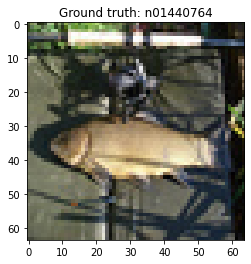

In [37]:
#@title Qualitative comparison with ground truth {run : "auto"}
datapoint_number : int = 1 #@param{type:"integer"}

dataset = cifar100_test if tuned_on == "cifar100" else imnet64_test
try:
    visualize(datapoint_number, dataset)
    label : int = predict(dataset[datapoint_number][0], teacher, feature_extractor)
    prediction : str = teacher.config.id2label[label]
    print(f"Predicted: {prediction}")
except IndexError:
    print(f"The dataset max index is {len(dataset)-1}")


In [11]:
#@title Quantitative result: Accuracy
'''
Warning: this cell takes 15min to be executed (on GPU).
'''
'''
correct = 0
for i in tqdm(range(len(dataset))):
    pr_label = predict(dataset[i][0], teacher, feature_extractor)
    gt_label = dataset[i][1]
    if pr_label == gt_label:
        correct += 1
accuracy = round(correct*100 / len(dataset),2)
print(f"The accuracy of the model for the dataset {tuned_on} is: {accuracy}%")
'''
##### TODO remove (?) ####

'\ncorrect = 0\nfor i in tqdm(range(len(dataset))):\n    pr_label = predict(dataset[i][0], teacher, feature_extractor)\n    gt_label = dataset[i][1]\n    if pr_label == gt_label:\n        correct += 1\naccuracy = round(correct*100 / len(dataset),2)\nprint(f"The accuracy of the model for the dataset {tuned_on} is: {accuracy}%")\n'

###1.2 Student (MLP mixer)
The code for the MLP mixer was taken from this repository: [image_models](https://github.com/rwightman/pytorch-image-models).

Credit: [Ross Wightman](https://github.com/rwightman) 

In [38]:
#@title [Timm](https://huggingface.co/docs/timm/index) implementation
class LitMixer(pl.LightningModule):
    def __init__(self,
                 num_classes : int,
                 img_size : int,
                 patch_size : int,
                 num_blocks : int,
                 embed_dim : int,
                 in_chans : int = 3,
                 drop_rate : float = 0.0,
                 drop_path_rate : float = 0.0,
                 learning_rate : float = 0.001,
                 act_layer : Callable = nn.GELU,
                 distillating : str = None,
                 distillation_prob : float = None):
        super().__init__()
        assert(distillation_prob is None or distillating != "random")

        self.mixer = timm.models.mlp_mixer.MlpMixer(num_classes = num_classes,
                     img_size = img_size,
                     in_chans = in_chans,
                     patch_size = patch_size,
                     num_blocks = num_blocks,
                     act_layer = act_layer,
                     drop_rate = drop_rate,
                     drop_path_rate = drop_path_rate,
                     embed_dim = embed_dim)

        self.lr = learning_rate
        self.distillating = distillating
        self.distillation_prob = distillation_prob

        self.loss_fn = nn.CrossEntropyLoss()

        ## logging attributes
        self.loss = { "train" : 0, "val" : 0, "test" : 0 }
        self.accuracy = { "train" : 0, "val" : 0, "test" : 0 }
        self.tot = { "train" : 0, "val" : 0, "test" : 0 }
        self.first_test = True

        super().save_hyperparameters()
    
    def step(self, batch : torch.Tensor ,step_type : str) -> torch.Tensor:
        # get ground truth and data
        if step_type == "test":
            data, labels = batch
            gt : torch.Tensor = labels
        else:
            data, labels, teacher_labels = batch
            if self.distillating is None:
                gt : torch.Tensor = labels
            else:
                teacher_labels = torch.nn.functional.softmax(teacher_labels, dim = -1)
                if self.distillating == "soft":
                    gt : torch.Tensor = teacher_labels
                elif self.distillating == "hard":
                    gt : torch.Tensor = teacher_labels.argmax(dim = -1)
                elif self.distillating == "random":
                    r : float = random.random()
                    if r <= self.distillation_prob:
                        gt : torch.Tensor = teacher_labels
                    else:
                        gt : torch.Tensor = labels
                elif self.distillating == "weighted":
                    gt = labels
                    gt_t : torch.Tensor = teacher_labels
        
        batch_size : int = labels.shape[0]

        # compute predictions
        logits = self.mixer(data.float())
        if self.distillating == "weighted" and step_type != "test":
          loss = 0.3 * self.loss_fn(logits,gt) + 0.7 * self.loss_fn(logits,gt_t)
        else:
          loss = self.loss_fn(logits,gt)
        predictions = logits.argmax(dim = -1)

        # update logging variables
        self.loss[step_type] += loss.item()
        self.accuracy[step_type]  += (predictions == labels).sum().item()
        self.tot[step_type]  += batch_size

        return loss

    def training_step(self, batch : torch.Tensor ,batch_idx : int):
        return self.step(batch,"train")
    
    def validation_step(self,batch,batch_idx):
        return self.step(batch,"val")
    
    def test_step(self,batch,batch_idx):
        return self.step(batch,"test")
    
    def epoch_end(self, step_type : str, num_outputs : int) -> None:
        # compute loss
        avg_loss = self.loss[step_type] / num_outputs
        self.loss[step_type] = 0
        # compute accuracy
        accuracy = self.accuracy[step_type] / self.tot[step_type]
        self.accuracy[step_type] = 0
        self.tot[step_type] = 0
        # log
        self.log("epoch", float(self.current_epoch))
        if step_type != "test":
            self.log(f"{step_type}_loss",avg_loss)
            self.log(f"{step_type}_accuracy",accuracy)
        elif self.first_test:
          self.log("test_loss_before",avg_loss)
          self.log("test_accuracy_before",accuracy)
          self.first_test = False
        else:
          self.log("test_loss_after",avg_loss)
          self.log("test_accuracy_after",accuracy)
    
    def training_epoch_end(self, outputs) -> None:
        self.epoch_end("train",len(outputs))
    
    def validation_epoch_end(self, outputs) -> None:
        self.epoch_end("val",len(outputs))
    
    def test_epoch_end(self, outputs) -> None:
        self.epoch_end("test",len(outputs))

    def configure_optimizers(self) -> torch.optim:
        return torch.optim.AdamW(self.mixer.parameters(), lr = self.lr)

In [39]:
#@title Student instantiation
trained_on : str = "imagenet" #@param["cifar100","imagenet"]
patch_size : int = 4 #@param{type: "integer"}
num_blocks : int = 6 #@param{type: "integer"}
embed_dim  : int = 128 #@param{type: "integer"}
drop_rate : float = 0.24 #@param{type:"number"}
drop_path_rate : float = 0.25 #@param{type:"number"}
learning_rate : float = 0.0025 #@param{type:"number"}
distillating : str = "weighted" #@param["soft","hard","random","weighted","no"]
distillation_prob : float = 0. #@param{type:"number"}
if trained_on == "cifar100":
    num_classes = 100
    img_size = 32
else:
    num_classes = 1000
    img_size = 64 
student = LitMixer(num_classes = num_classes, 
                   img_size = img_size,
                   patch_size = patch_size,
                   num_blocks = num_blocks,
                   embed_dim = embed_dim,
                   drop_rate = drop_rate,
                   drop_path_rate = drop_path_rate,
                   learning_rate = learning_rate,
                   distillating = distillating if distillating != "no" else None,
                   distillation_prob = distillation_prob if distillating == "random" else None,
                   )
print('Trainable Parameters: %.3fM' % count_params(student))

Trainable Parameters: 0.863M


##2. Distillation

###2.1 Computing labels


First of all we want to compute once and for all the teacher scores of the images:

In [40]:
def compute_scores(dataset : torch.utils.data.Dataset,
                   teacher : torch.nn.Module, 
                   teacher_extractor : Any, # a feature extractor
                   num_classes : int) -> torch.Tensor:
    teacher_label = torch.zeros(len(dataset), num_classes)
    for i,(image,_) in tqdm(enumerate(dataset)):
        features = teacher_extractor(image,return_tensors="pt").to(device)
        with torch.no_grad():
            label = teacher(**features).logits
        teacher_label[i,:] = label
    return teacher_label

###2.2 Creating custom datasets

In [41]:
#@title Distillation dataset
class DistillDataset(torch.utils.data.Dataset):
    '''
    A dataset for the distillation training.
    This dataset wraps the original dataset toghether with the teacher ground truth.
    '''
    def __init__(self, 
                 original_dataset : torch.utils.data.Dataset,
                 teacher_label_path : Path = None,
                 teacher_model : torch.nn.Module = None,
                 teacher_extractor : Any = None,
                 save : bool = True, 
                 dataset_name : str = "cifar100"
                 ):
        assert(teacher_label_path is not None or teacher_model is not None)
        super().__init__()
        file_name = 'cifar100.pt' if dataset_name == "cifar100" else "imnet64.pt"
        self.dataset = original_dataset
        
        num_classes = len(self.dataset.classes) if dataset_name == "cifar100" else 1000
        
        if not os.path.exists(teacher_label_path):
          os.makedirs(teacher_label_path)
          self.teacher_label = compute_scores(self.dataset, 
                                                teacher_model,
                                                teacher_extractor,
                                                num_classes
                                                )
          
          if save:
                with open(os.path.join(teacher_label_path , file_name), "wb") as tl:
                    torch.save(self.teacher_label,tl)
        
        else:
         
            with open(os.path.join(teacher_label_path , file_name), "rb") as dl:
                  self.teacher_label = torch.load(dl)

    
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, index):
        return self.dataset[index][0], self.dataset[index][1] , self.teacher_label[index]

In [43]:
#@title Train/Validation split
val_perc : float = 0.15 #@param{type:"number"}
dataset = DistillDataset(imnet64_train, 
                         "teacher_labels_imnet/",
                          teacher_model=teacher,
                          teacher_extractor = feature_extractor,
                          dataset_name = "imnet64"
                         )
train_len = int((1-val_perc) * len(dataset))
val_len = len(dataset) - train_len
train_dataset, val_dataset = torch.utils.data.random_split(dataset,
                                                           lengths = [train_len, val_len],
                                                           generator=torch.Generator("cpu").manual_seed(seed))

70964it [30:26, 38.86it/s]


KeyboardInterrupt: 

In [ ]:
#@title Pytorch Lightning datamodule definition
class DistillDataModule(pl.LightningDataModule):
    def __init__(self, train_dataset, val_dataset, test_dataset, batch_size):
        super().__init__()
        self.train_dataset = train_dataset
        self.val_dataset = val_dataset
        self.test_dataset = test_dataset
        self.batch_size = batch_size
    
    def train_dataloader(self) -> torch.utils.data.DataLoader:
       return torch.utils.data.DataLoader(self.train_dataset, batch_size = self.batch_size, shuffle = True)

    def val_dataloader(self) -> torch.utils.data.DataLoader:
       return torch.utils.data.DataLoader(self.val_dataset, batch_size = self.batch_size, shuffle = False)
    
    def test_dataloader(self) -> torch.utils.data.DataLoader:
       return torch.utils.data.DataLoader(self.test_dataset, batch_size = self.batch_size, shuffle = False)

In [ ]:
#@title Create a datamodule
batch_size : int = 128 #@param{type:"integer"}
datamodule = DistillDataModule(train_dataset,val_dataset,imnet64_test,batch_size = batch_size)

###2.3 Training the student

In [ ]:
#@title Weights & Biases initialization

run_name : str = "imnet_small_student" #@param{type:"string"}

#login
wandb.login
wandb.init(project="mixer-kd", entity='mixer-kd')
wandb.run.name = run_name

#definition of the metrics to compute
wandb.define_metric('epoch')
wandb.define_metric('train_loss',step_metric='epoch')
wandb.define_metric('test_loss_before',step_metric='epoch')
wandb.define_metric('test_loss_after',step_metric='epoch')
wandb.define_metric('val_loss',step_metric='epoch')
wandb.define_metric('train_accuracy',step_metric='epoch')
wandb.define_metric('val_accuracy',step_metric='epoch')
wandb.define_metric('test_accuracy_before',step_metric='epoch')
wandb.define_metric('test_accuracy_after',step_metric='epoch')

#config of the run
wandb.config.batch_size = batch_size
wandb.config.val_perc = val_perc

#definition of the pytorch lightning logger
logger = pl.loggers.WandbLogger(name='run_1', project='mixer-kd')

In [ ]:
#@title Train the student
epochs : int = 60 #@param{type:"integer"}

# checkpoint to save the model with the best validation loss
checkpoint = callbacks.ModelCheckpoint("checkpoints/",
                                       monitor="val_loss",
                                       mode="min")

# definition of the triner
trainer = pl.Trainer(max_epochs=epochs,
                     accelerator=device,
                     logger=logger,
                     callbacks=[checkpoint]
                     )

# training
logger.watch(student)
trainer.test(datamodule=datamodule,model = student) #test before training
trainer.fit(datamodule=datamodule,model = student) #trainng
student = LitMixer.load_from_checkpoint(checkpoint.best_model_path)
student.first_test = False
trainer.test(datamodule=datamodule,model = student) #test after training
wandb.finish()

In [22]:
#@title Load a model from checkpoint
checkpoint_path : str = "last_checkpoint" #@param{type:"string"}
if checkpoint_path == "last_checkpoint":
    checkpoint_path = checkpoint.best_model_path
loaded_student = LitMixer.load_from_checkpoint(checkpoint_path)

('woman', 'lamp')

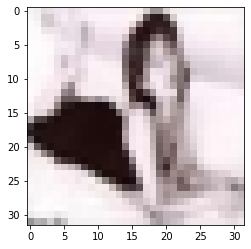

In [24]:
#@title Test qualitative results {run : 'auto'}
datapoint_number = 600 #@param{type : "integer"}
image, gt = cifar100_test[datapoint_number]
image_pixels = torchvision.transforms.functional.to_pil_image(image)
plt.imshow(image_pixels)
pr = loaded_student.mixer(image.unsqueeze(0).float())
#print(pr)
dataset.dataset.classes[gt],  dataset.dataset.classes[pr.argmax().item()]